## Basic Setting

In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

## Laod data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/111/ML/NFLX.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-20,351.230011,352.420013,345.399994,348.109985,348.109985,4621500
1,2019-05-21,350.950012,356.429993,349.929993,354.269989,354.269989,4026400
2,2019-05-22,358.010010,370.459991,357.299988,359.730011,359.730011,6229400
3,2019-05-23,355.500000,357.420013,347.700012,352.209991,352.209991,5630400
4,2019-05-24,355.410004,359.440002,353.790009,354.390015,354.390015,3831000
...,...,...,...,...,...,...,...
1003,2023-05-12,344.760010,348.170013,337.359985,339.890015,339.890015,6079900
1004,2023-05-15,340.619995,341.899994,335.540009,335.890015,335.890015,3653000
1005,2023-05-16,334.000000,335.170013,331.910004,333.750000,333.750000,3332200
1006,2023-05-17,331.760010,341.380005,329.619995,339.959991,339.959991,3958800


In [4]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2019-05-20,348.109985
1,2019-05-21,354.269989
2,2019-05-22,359.730011
3,2019-05-23,352.209991
4,2019-05-24,354.390015


In [5]:
new_df.describe().round(2)

,Close
count,1008.00
mean,402.77
std,126.48
min,166.37
25%,305.44
50%,374.54
75%,509.09
max,691.69


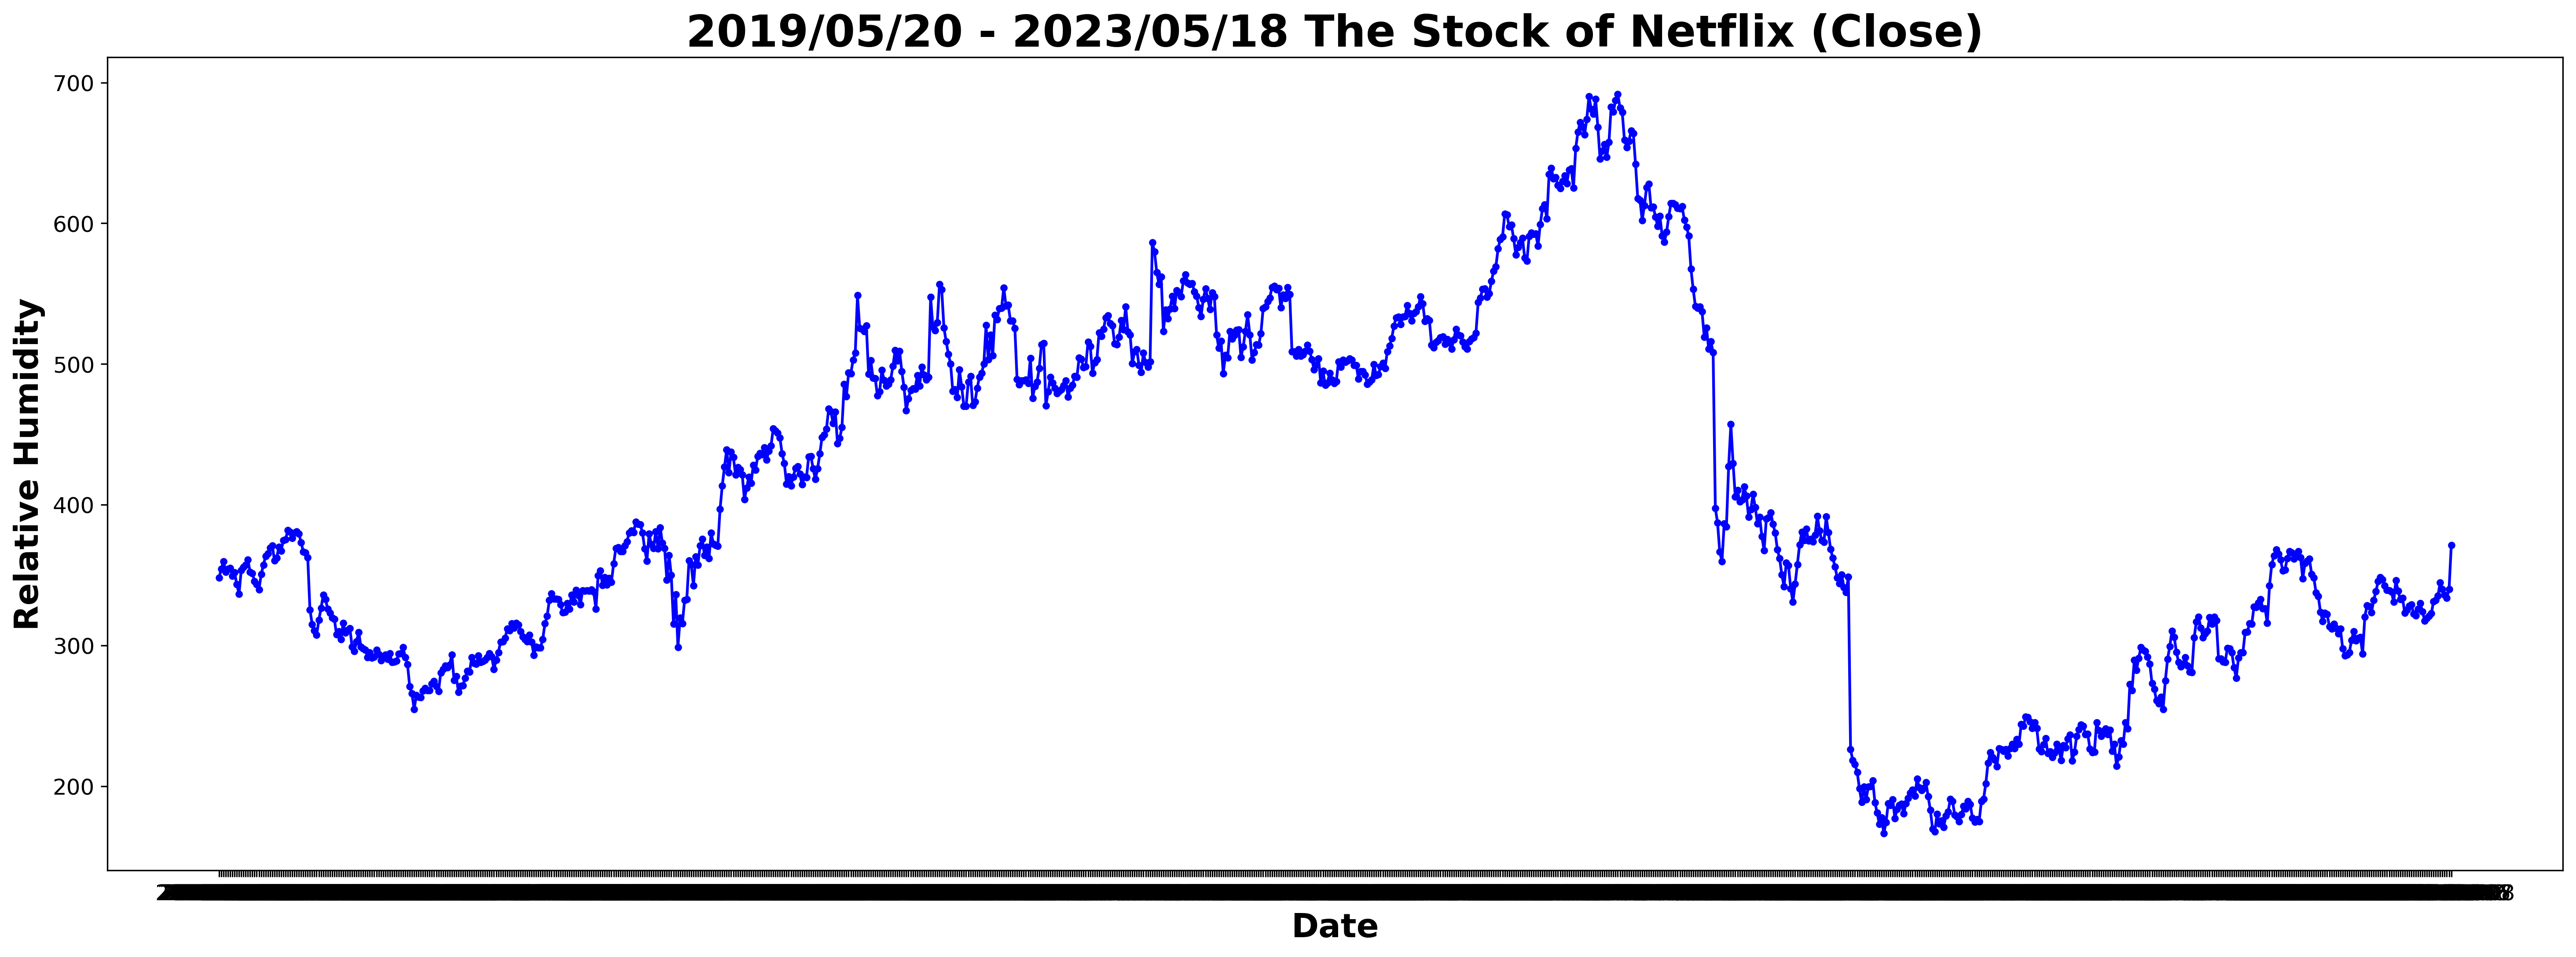

In [6]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('2019/05/20 - 2023/05/18 The Stock of Netflix (Close)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Creating lags

In [7]:
new_df['close_Lag1']=new_df['Close'].shift(1).copy()
new_df['close_Lag2']=new_df['Close'].shift(2).copy()
new_df['close_Lag3']=new_df['Close'].shift(3).copy()
new_df

,Date,Close,close_Lag1,close_Lag2,close_Lag3
0,2019-05-20,348.109985,NaN,NaN,NaN
1,2019-05-21,354.269989,348.109985,NaN,NaN
2,2019-05-22,359.730011,354.269989,348.109985,NaN
3,2019-05-23,352.209991,359.730011,354.269989,348.109985
4,2019-05-24,354.390015,352.209991,359.730011,354.269989
...,...,...,...,...,...
1003,2023-05-12,339.890015,344.760010,335.420013,332.140015
1004,2023-05-15,335.890015,339.890015,344.760010,335.420013
1005,2023-05-16,333.750000,335.890015,339.890015,344.760010
1006,2023-05-17,339.959991,333.750000,335.890015,339.890015


In [8]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,close_Lag1,close_Lag2,close_Lag3
0,2019-05-23,352.209991,359.730011,354.269989,348.109985
1,2019-05-24,354.390015,352.209991,359.730011,354.269989
2,2019-05-28,355.059998,354.390015,352.209991,359.730011
3,2019-05-29,349.190002,355.059998,354.390015,352.209991
4,2019-05-30,351.850006,349.190002,355.059998,354.390015
...,...,...,...,...,...
1000,2023-05-12,339.890015,344.760010,335.420013,332.140015
1001,2023-05-15,335.890015,339.890015,344.760010,335.420013
1002,2023-05-16,333.750000,335.890015,339.890015,344.760010
1003,2023-05-17,339.959991,333.750000,335.890015,339.890015


## Data preprocessing

In [9]:
# Train data
Forecast_train_data = clean_df.iloc[0:909+1,:].copy()
Forecast_train_data

,Date,Close,close_Lag1,close_Lag2,close_Lag3
0,2019-05-23,352.209991,359.730011,354.269989,348.109985
1,2019-05-24,354.390015,352.209991,359.730011,354.269989
2,2019-05-28,355.059998,354.390015,352.209991,359.730011
3,2019-05-29,349.190002,355.059998,354.390015,352.209991
4,2019-05-30,351.850006,349.190002,355.059998,354.390015
...,...,...,...,...,...
905,2022-12-23,294.959991,297.750000,297.959991,288.190002
906,2022-12-27,284.170013,294.959991,297.750000,297.959991
907,2022-12-28,276.880005,284.170013,294.959991,297.750000
908,2022-12-29,291.119995,276.880005,284.170013,294.959991


In [10]:
# Test data
Forecast_test_data = clean_df.iloc[910:1004+1, :].copy()
Forecast_test_data

,Date,Close,close_Lag1,close_Lag2,close_Lag3
910,2023-01-03,294.950012,294.880005,291.119995,276.880005
911,2023-01-04,309.410004,294.950012,294.880005,291.119995
912,2023-01-05,309.700012,309.410004,294.950012,294.880005
913,2023-01-06,315.549988,309.700012,309.410004,294.950012
914,2023-01-09,315.170013,315.549988,309.700012,309.410004
...,...,...,...,...,...
1000,2023-05-12,339.890015,344.760010,335.420013,332.140015
1001,2023-05-15,335.890015,339.890015,344.760010,335.420013
1002,2023-05-16,333.750000,335.890015,339.890015,344.760010
1003,2023-05-17,339.959991,333.750000,335.890015,339.890015


## Train & Validation

* Expanding Window

In [11]:
# Expanding 1
Exp_training_1 = Forecast_train_data.iloc[0:215+1, :].copy()
Exp_val_1 = Forecast_train_data.iloc[216:444+1, :].copy()

# Expanding 2
Exp_training_2 = Forecast_train_data.iloc[0:444+1,:].copy()
Exp_val_2 = Forecast_train_data.iloc[445:678+1, :].copy()

# Expanding 3
Exp_training_3 = Forecast_train_data.iloc[0:678+1,:].copy()
Exp_val_3 = Forecast_train_data.iloc[679:909+1,:].copy()

In [34]:
Exp_val_3

,Date,Close,close_Lag1,close_Lag2,close_Lag3
679,2022-02-01,457.130005,427.140015,384.359985,386.700012
680,2022-02-02,429.480011,457.130005,427.140015,384.359985
681,2022-02-03,405.600006,429.480011,457.130005,427.140015
682,2022-02-04,410.170013,405.600006,429.480011,457.130005
683,2022-02-07,402.100006,410.170013,405.600006,429.480011
...,...,...,...,...,...
905,2022-12-23,294.959991,297.750000,297.959991,288.190002
906,2022-12-27,284.170013,294.959991,297.750000,297.959991
907,2022-12-28,276.880005,284.170013,294.959991,297.750000
908,2022-12-29,291.119995,276.880005,284.170013,294.959991


## Set X & Y

#### Expanding 1

In [39]:
#set x (make prediction)
# Train
x_train=Exp_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['close_Lag1','close_Lag2','close_Lag3']

# Validation
x_val=Exp_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['close_Lag1','close_Lag2','close_Lag3']

#set y (want to predict)
y_train=Exp_training_1['Close'].copy()
y_val=Exp_val_1['Close'].copy()

In [46]:
x_train

,close_Lag1,close_Lag2,close_Lag3
0,359.730011,354.269989,348.109985
1,352.209991,359.730011,354.269989
2,354.390015,352.209991,359.730011
3,355.059998,354.390015,352.209991
4,349.190002,355.059998,354.390015
...,...,...,...
440,540.219971,548.219971,551.340027
441,533.780029,540.219971,548.219971
442,546.150024,533.780029,540.219971
443,553.409973,546.150024,533.780029


#### Expanding 2

In [57]:
#set x (make prediction)
# Train
x_train=Exp_training_2.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['close_Lag1','close_Lag2','close_Lag3']

# Validation
x_val=Exp_val_2.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['close_Lag1','close_Lag2','close_Lag3']

#set y (want to predict)
y_train=Exp_training_2['Close'].copy()
y_val=Exp_val_2['Close'].copy()

#### Expanding 3

In [50]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['close_Lag1','close_Lag2','close_Lag3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['close_Lag1','close_Lag2','close_Lag3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [58]:
x_train

,close_Lag1,close_Lag2,close_Lag3
0,359.730011,354.269989,348.109985
1,352.209991,359.730011,354.269989
2,354.390015,352.209991,359.730011
3,355.059998,354.390015,352.209991
4,349.190002,355.059998,354.390015
...,...,...,...
440,540.219971,548.219971,551.340027
441,533.780029,540.219971,548.219971
442,546.150024,533.780029,540.219971
443,553.409973,546.150024,533.780029


## Create Net

In [13]:
scaled_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close_Lag1  216 non-null    float64
 1   close_Lag2  216 non-null    float64
 2   close_Lag3  216 non-null    float64
dtypes: float64(3)
memory usage: 5.2 KB


In [41]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,close_Lag1,close_Lag2,close_Lag3
0,0.789399,0.748404,0.702155
1,0.732938,0.789399,0.748404
2,0.749306,0.732938,0.789399
3,0.754336,0.749306,0.732938
4,0.710264,0.754336,0.749306


In [15]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


## Define RMSE

In [16]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

## Sequential style coding for creating net

* Learning_rate = 0.1/ 0.001/ 0.05
* Momentum = 0.9/ 0.05/ 0.5
* hidden_layer = 3 /4 /5

#### 2 Layers

In [ ]:
for learning_rate in [0.1, 0.001, 0.05]:
  for beta_1 in [0.9, 0.5, 0.005]:
    # 6.1 Create the model
    clear.clear_session()
    model=Sequential()

    # 6.2 Add input layer & first hidden layer
    model.add(Dense(units=6, input_dim=3, activation='relu'))

    # 6.3 Add second hidden layer
    model.add(Dense(units=12, activation='linear'))

    # 6.5 Add output layer
    model.add(Dense(units=1, activation='linear'))

    # # 6.4 Add third hidden layer
    # model.add(Dense(units=24, activation='relu'))

    # 6.6 Compile the defined Net
    #opt=SGD(learning_rate=0.001,momentum=0.5)
    opt=Adam(learning_rate = learning_rate, beta_1 = beta_1)
    model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

    history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))
    print("----------------learning_rate:", learning_rate)
    print("----------------beta_1:", beta_1)

    # # Finally check the model 
    # model.summary()

#### 3 Layers

In [ ]:
for learning_rate in [0.1, 0.001, 0.05]:
  for beta_1 in [0.9, 0.5, 0.005]:
    # 6.1 Create the model
    clear.clear_session()
    model=Sequential()

    # 6.2 Add input layer & first hidden layer
    model.add(Dense(units=6, input_dim=3, activation='relu'))

    # 6.3 Add second hidden layer
    model.add(Dense(units=12, activation='linear'))

    # 6.4 Add third hidden layer
    model.add(Dense(units=24, activation='relu'))

    # 6.5 Add output layer
    model.add(Dense(units=1, activation='linear'))

    # 6.6 Compile the defined Net
    #opt=SGD(learning_rate=0.001,momentum=0.5)
    opt=Adam(learning_rate = learning_rate, beta_1 = beta_1)
    model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

    history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))
    print("----------------learning_rate:", learning_rate)
    print("----------------beta_1:", beta_1)

    # # Finally check the model 
    # model.summary()

#### 4 Layers

In [ ]:
for learning_rate in [0.1, 0.001, 0.05]:
  for beta_1 in [0.9, 0.5, 0.005]:
    # 6.1 Create the model
    clear.clear_session()
    model=Sequential()

    # 6.2 Add input layer & first hidden layer
    model.add(Dense(units=6, input_dim=3, activation='relu'))

    # 6.3 Add second hidden layer
    model.add(Dense(units=12, activation='linear'))

    # 6.4 Add third hidden layer
    model.add(Dense(units=24, activation='relu'))

    # 6.* Add forth hidden layer
    model.add(Dense(units=48, activation='linear'))

    # 6.5 Add output layer
    model.add(Dense(units=1, activation='linear'))

    # 6.6 Compile the defined Net
    #opt=SGD(learning_rate=0.001,momentum=0.5)
    opt=Adam(learning_rate = learning_rate, beta_1 = beta_1)
    model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

    history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))
    print("----------------learning_rate:", learning_rate)
    print("----------------beta_1:", beta_1)

    # # Finally check the model 
    # model.summary()

## Fit the model（train/validation）

### MIN

In [64]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate = 0.05, beta_1 = 0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

### MEDIAN

In [69]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate = 0.1, beta_1 = 0.005)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

### Plot

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

## Fit the final model with all of the training data

In [85]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate = 0.05, beta_1 = 0.5)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

In [ ]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

In [ ]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('NFLX_ANN_trained_model.h5')
print('Model has been saved...')

In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/NFLX_ANN_trained_model.h5')
print('Model successfully loaded...')

## Testing

In [92]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [93]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

##  Plot for comparing true value & predicted value 

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('2019/05/20 - 2023/05/18 The Stock of Netflix (Close)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[800:,0],clean_df.iloc[800:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

## Actual by predicted plot

In [ ]:
# Lock the scale of axis by Y_true
max_value=500+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()